In [86]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [87]:
store_sales = pd.read_csv("train.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [88]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [89]:
store_sales = store_sales.drop(['store','item'], axis=1)

In [90]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


converting date from object datatype to dataTime datatype

In [91]:
store_sales['date'] = pd.to_datetime(store_sales['date'])


In [92]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


converting date to a Month period, and then sum of the number of items in each month



In [93]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [94]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [95]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


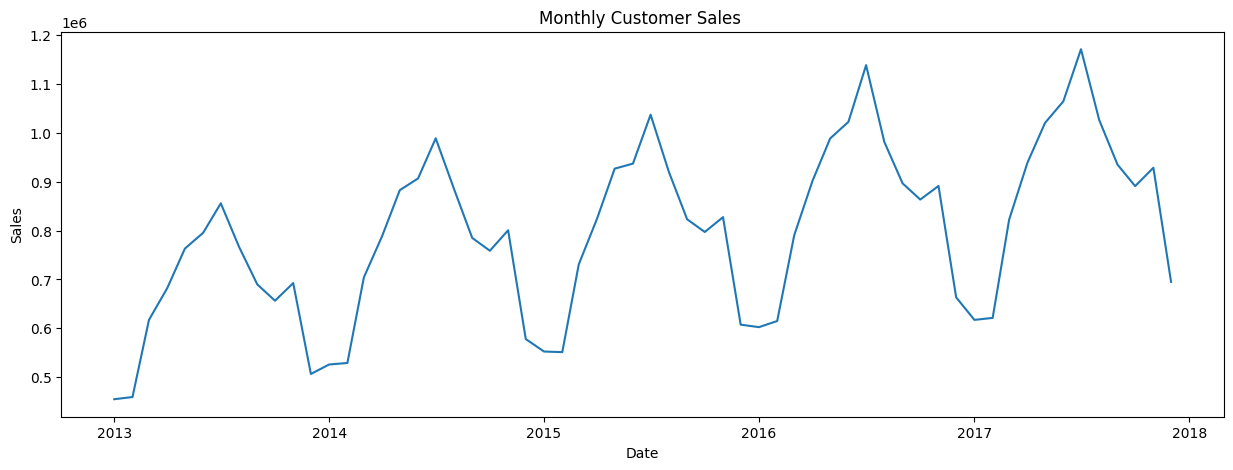

In [96]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales ")
plt.show()



In [97]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


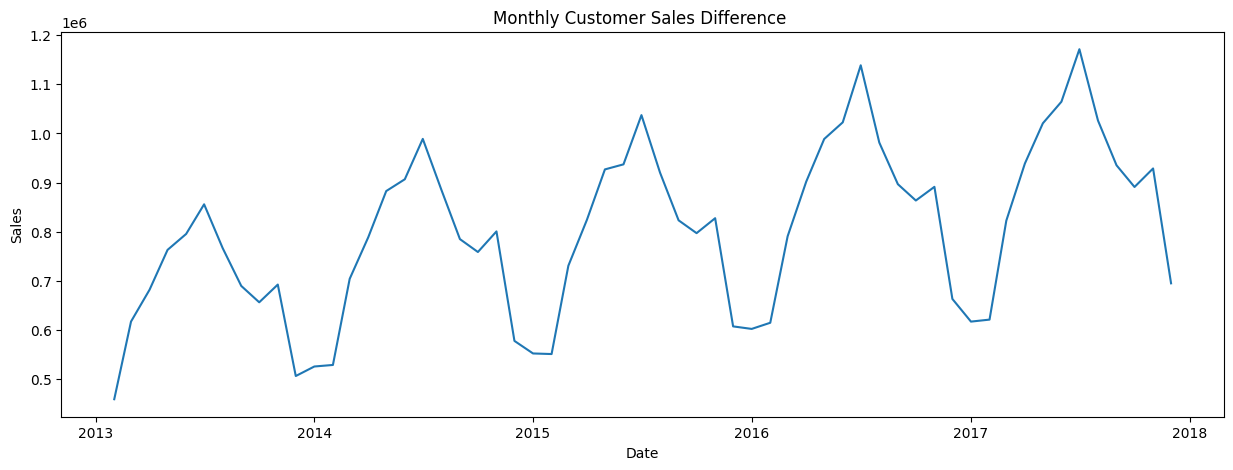

In [98]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Customer Sales Difference ")
plt.show()

In [99]:
supervised_data =  monthly_sales.drop(['date', 'sales'], axis=1)

In [100]:
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


splits the data into trian and test data

In [101]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape:", train_data.shape)
print("Test Data SHape:", test_data.shape)

Train Data Shape: (35, 13)
Test Data SHape: (12, 13)


In [102]:
 scaler = MinMaxScaler(feature_range=(-1,1))
 scaler.fit(train_data)
 train_data = scaler.transform(train_data)
 test_data = scaler.transform(test_data)

In [103]:
x_train, y_train = train_data[:,1:],train_data[:,0:1]
x_test, y_test = test_data[:,1:],train_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train Shape:", x_train.shape)
print("y_train Shape:", y_train.shape)
print("x_test Shape:", x_test.shape)
print("y_test Shape:", y_test.shape)



x_train Shape: (35, 12)
y_train Shape: (35,)
x_test Shape: (12, 12)
y_test Shape: (35,)


Making predictions data frames to merge the predicted sales prices of all trained algorithms

In [104]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

actual sales in last 13 months to list out

In [105]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


forecasting using linear regression model(predicted inputs aligns with desired output)

In [106]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pre = lr_model.predict(x_test)


In [107]:
lr_pre = lr_pre.reshape(-1,1)
#test matix - contains the input features of the data and also the predicted ot
lr_pre_test_set = np.concatenate([lr_pre, x_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)


In [108]:
result_list =[]
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

finding out the actual and predicted values from linear regression

mean abs error

In [109]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score = (predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linear Regression MSE:", lr_mse )
print("Linear Regression MAE:", lr_mae )
print("Linear Regression R2:", lr_r2 )

Linear Regression MSE: 16221.272385416869
Linear Regression MAE: 263129677.80188787
Linear Regression R2: (0     6.479148e+05
1     6.283374e+05
2     8.195190e+05
3     9.436391e+05
4     1.033653e+06
5     1.065286e+06
6     1.201561e+06
7     1.002123e+06
8     9.415142e+05
9     9.080646e+05
10    9.167461e+05
11    6.947978e+05
Name: Linear Prediction, dtype: float64, 48     617306
49     621369
50     822667
51     938862
52    1020686
53    1064624
54    1171393
55    1026403
56     935263
57     891160
58     928837
59     695170
Name: sales, dtype: int64)


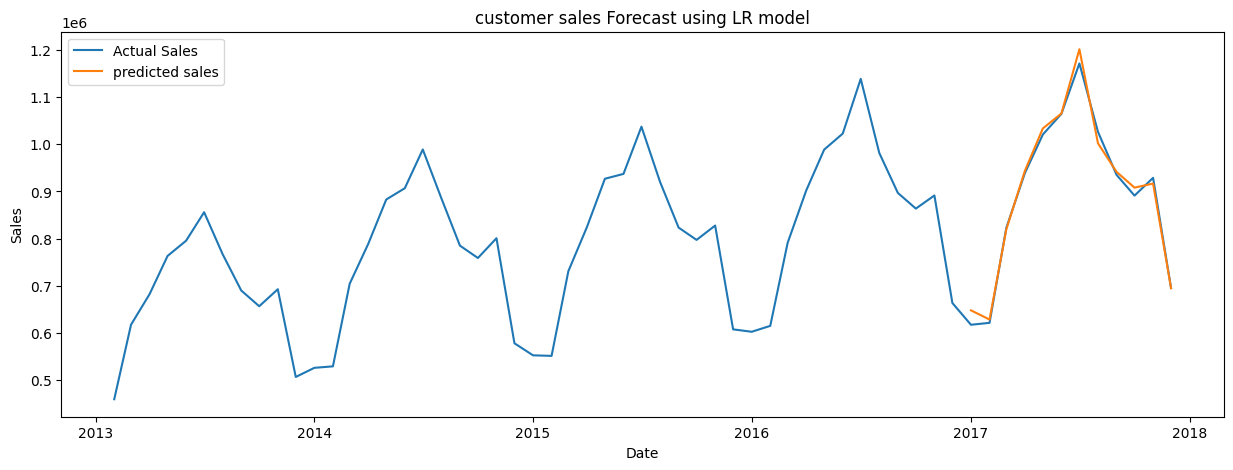

In [112]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("customer sales Forecast using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'predicted sales'])
plt.show()